In [ ]:
cd ..



In [2]:
from torch import nn

import torch
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import trange

from Metrics.SSGE import SpectralSteinEstimator
from Metrics.KLdivergence import KL
from Tools import NormalLogLikelihood

import seaborn as sns

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Setup toy inference #

In [4]:

N=10 #dimension
n_samples=100 #used for estimation of the KL

n_points=10
x_data=torch.ones(1,n_points).to(device)
y_data=5*torch.ones(n_points,1).to(device)

sigma_noise=2.
def loglikelihood(x,y_data):
    pred=torch.matmul(x[:,0].view(x.shape[0],1,-1),x_data.view(1,1,n_points)).view(x.shape[0],n_points,-1)
    return NormalLogLikelihood(pred, y_data, sigma_noise).sum(1)




In [5]:

#prior distribution
sigma_prior=2.
target = torch.distributions.Normal(torch.zeros(N,device=device), sigma_prior*torch.ones(N,device=device))


In [6]:
A=(sigma_noise**-2) * n_points +(1/sigma_prior)*torch.eye(1)
mean_posterior_=(sigma_noise**-2)*torch.matmul(A.inverse()*x_data.cpu(),y_data.cpu())
sigma_posterior_=A.inverse()
mean_posterior=torch.cat([torch.Tensor([mean_posterior_.squeeze()]),torch.zeros(N-1)])
sigma_posterior=torch.cat([torch.Tensor([sigma_posterior_.squeeze()]),sigma_prior*torch.ones(N-1)])
posterior=torch.distributions.Normal(mean_posterior,sigma_posterior)
print(mean_posterior)
print(sigma_posterior)


tensor([4.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])
tensor([0.3333, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000])


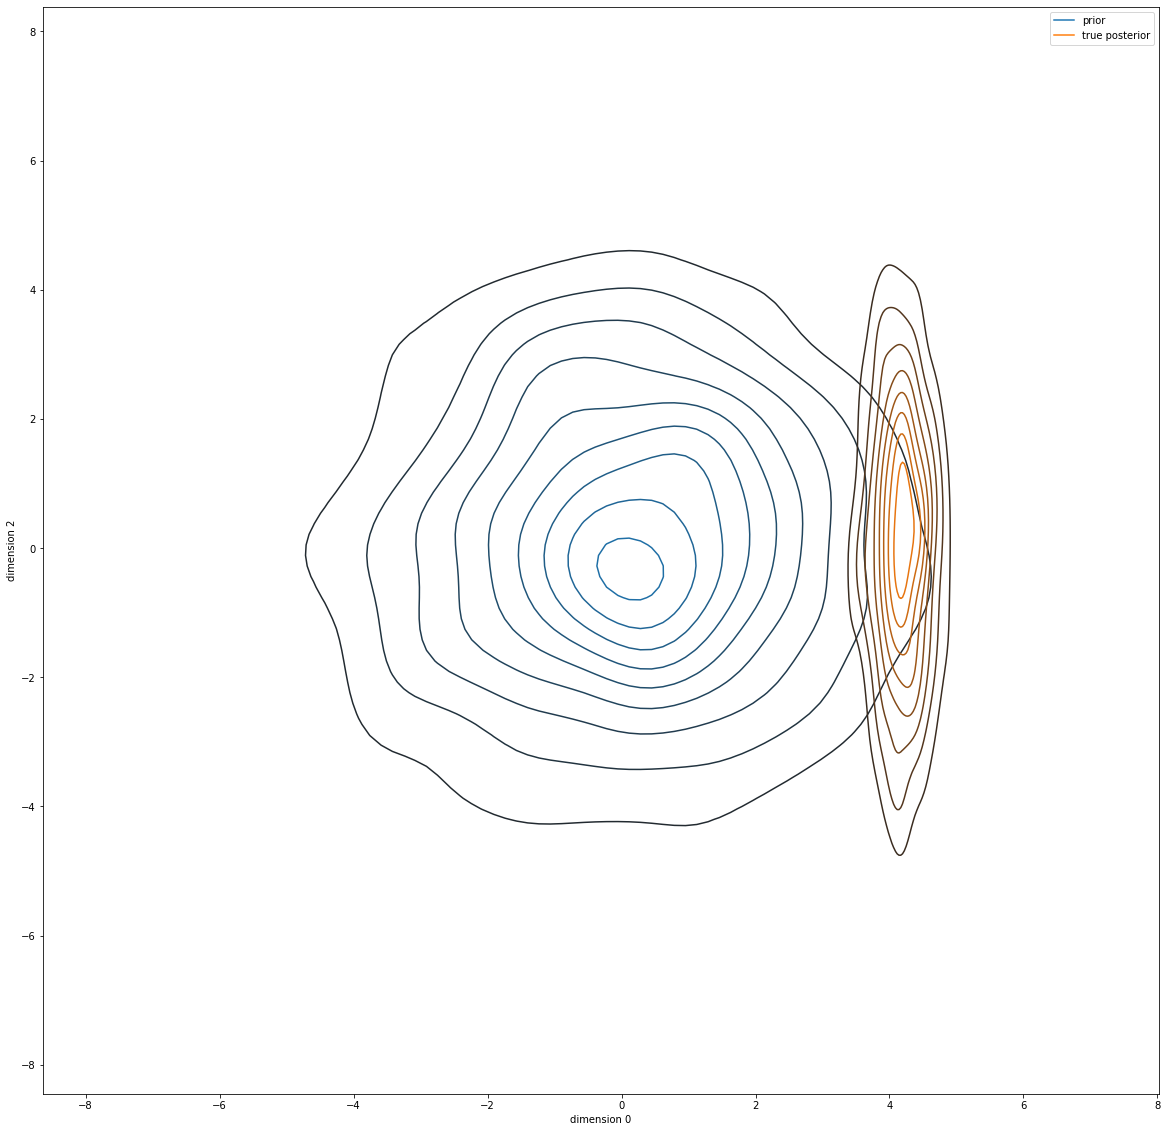

In [7]:

tar=target.sample((1000,)).cpu().numpy()
true_posterior=posterior.sample((1000,)).numpy()

plt.subplots(figsize=(20,20))

"""
sns.distplot(var, label='variationnel')
sns.distplot(tar,label='prior')
sns.distplot(data.cpu(),label='data')
sns.distplot(true_posterior, label='true posterior')
plt.legend()
"""
sns.kdeplot(tar[:,0],tar[:,1],label='prior')
dim=2
ax=sns.kdeplot(true_posterior[:,0],true_posterior[:,dim], label='true posterior')
ax.set(xlabel='dimension 0', ylabel='dimension {}'.format(dim))
plt.legend()

#plt.scatter(var[:,0],var[:,1],alpha=0.5, label='variationnel')
#plt.scatter(tar[:,0],tar[:,1],alpha=0.5)
#plt.legend()
#plt.axis('scaled')

# SSGE #

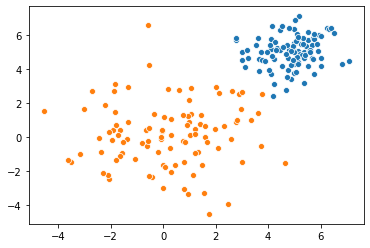

In [8]:
#p=torch.ones(N).detach().requires_grad_(True).to(device)
#q=5*torch.ones(N).detach().requires_grad_(True).to(device)
p=torch.ones(N).detach().requires_grad_(True).to(device)
q=5.*torch.ones(N).detach().requires_grad_(True).to(device)

x=torch.randn(n_samples,N).to(device)
var=(p*x+q).detach().cpu()
tar=target.sample((n_samples,)).cpu()

import seaborn as sns

#sns.distplot(var)
#sns.distplot(tar)

sns.scatterplot(var[:,0],var[:,1])
sns.scatterplot(tar[:,0],tar[:,1])


In [9]:
H_grad=[]

KLs=[]
ps=[]
qs=[]

In [10]:

lr=0.05
for _ in trange(1000):
    x=torch.randn(n_samples,N).to(device)

    n_samples=x.shape[0]
    sample=p*x+q

    lp=-2*target.log_prob(sample).mean()-2*loglikelihood(sample,y_data).mean()
    lp_grad_p=torch.autograd.grad(lp,p,retain_graph=True)[0]
    lp_grad_q=torch.autograd.grad(lp,q,retain_graph=True)[0]
    
    
    # Get the estimate of the score 
    score_estimator = SpectralSteinEstimator(eta=0.1)
    score = score_estimator(sample,sample)

    #compute gradients with respect to parameters
    H_grad_p = torch.autograd.grad(sample, p,
                          grad_outputs=score,
                          retain_graph=True)[0]/n_samples
    H_grad_q = torch.autograd.grad(sample, q,
                          grad_outputs=score,
                          retain_graph=True)[0]/n_samples

 #   KLs.append(KL(sample.view(-1,N),target.sample((n_samples,)),k=1,device='cpu').item())
    
   # print(lp_grad_p[0])
    
#    H_grad.append(entropy_grad)
    p.data.add_(-lr*(H_grad_p+lp_grad_p))
    q.data.add_(-lr*(H_grad_q+lp_grad_q))
    ps.append(p.data.clone())
    qs.append(q.data.clone())

100%|██████████| 1000/1000 [00:26<00:00, 37.12it/s]


In [11]:
print(q.data)
print(p.data)

tensor([4.9505, 0.4122, 0.4114, 0.4003, 0.4085, 0.3966, 0.3923, 0.4064, 0.3879,
        0.4125], device='cuda:0')
tensor([-8.4137e-08,  4.1998e+00,  4.2007e+00,  4.2002e+00,  4.2040e+00,
         4.1978e+00,  4.2212e+00,  4.2060e+00,  4.2121e+00,  4.1635e+00],
       device='cuda:0')


(1000, 10)


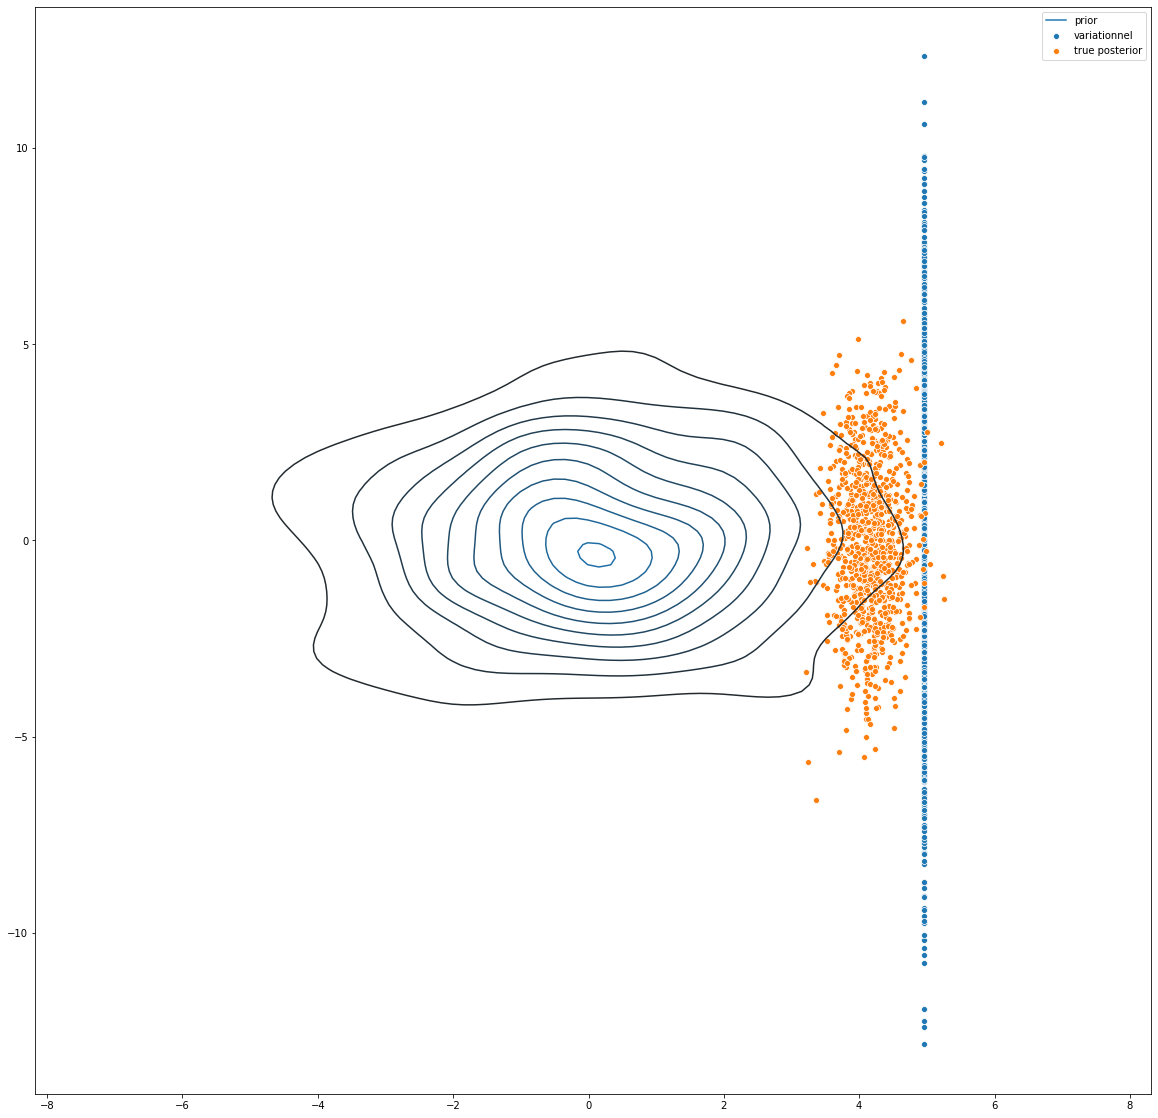

In [12]:
x=torch.randn(1000,N).to(device)
var=(p*x+q).detach().cpu().numpy()
tar=target.sample((1000,)).cpu().numpy()
print(var.shape)
true_posterior=posterior.sample((1000,)).numpy()

plt.subplots(figsize=(20,20))

"""
sns.distplot(var, label='variationnel')
sns.distplot(tar,label='prior')
sns.distplot(data.cpu(),label='data')
sns.distplot(true_posterior, label='true posterior')
plt.legend()
"""
sns.kdeplot(tar[:,0],tar[:,1],label='prior')
dim=2
sns.scatterplot(var[:,0],var[:,dim], label='variationnel')
sns.scatterplot(true_posterior[:,0],true_posterior[:,dim], label='true posterior')
plt.legend()

#plt.scatter(var[:,0],var[:,1],alpha=0.5, label='variationnel')
#plt.scatter(tar[:,0],tar[:,1],alpha=0.5)
#plt.legend()
#plt.axis('scaled')

(-6.742112517356873,
 7.314236521720886,
 -12.289049291610718,
 15.187916898727417)

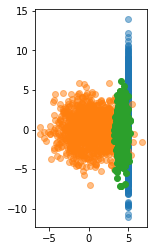

In [13]:
x=torch.randn(1000,N).to(device)
var=(p*x+q).detach().cpu()
tar=target.sample((1000,)).cpu()

plt.scatter(var[:,0],var[:,1],alpha=0.5)
plt.scatter(tar[:,0],tar[:,1],alpha=0.5)
plt.scatter(true_posterior[:,0],true_posterior[:,1], label='true posterior')

plt.axis('scaled')

torch.Size([999])


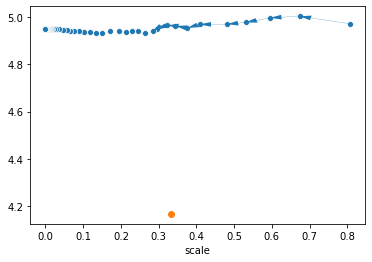

In [22]:
from matplotlib.collections import LineCollection
steps=-1
dim=0
p0=torch.stack(ps)[:steps,dim].cpu()
q0=torch.stack(qs)[:steps,dim].cpu()

import numpy as np


line=sns.scatterplot(p0.cpu(),q0.cpu())

mid=1#1*(len(p0)//10)
eps=1
for mid in range(10):
    arrow = p0[mid], q0[mid], -p0[mid]+p0[mid+eps], -q0[mid]+q0[mid+eps]
    plt.arrow(*arrow, shape='full', lw=0, length_includes_head=True, head_width=.02)
plt.scatter(sigma_posterior[dim],mean_posterior[dim], marker='o',label='target')
ax.set_ylabel("mode")
plt.xlabel("scale")

print(p0.shape)

Text(0.5, 0, 'scale')

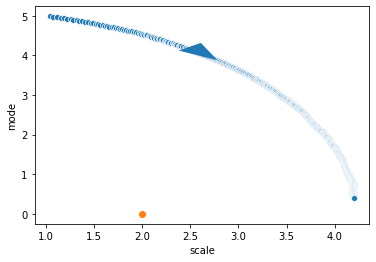

In [19]:
dim=1
p0=torch.stack(ps)[:,dim].cpu()
q0=torch.stack(qs)[:,dim].cpu()

fig,ax=plt.subplots()
sns.scatterplot(p0.cpu(),q0.cpu())
ax.set_ylabel("mode")

mid=100#1*(len(p0)//10)
eps=1
arrow = p0[mid], q0[mid], -p0[mid]+p0[mid+eps], -q0[mid]+q0[mid+eps]
plt.arrow(*arrow, shape='full', lw=0, length_includes_head=True, head_width=.3)
plt.scatter(sigma_posterior[dim],mean_posterior[dim], marker='o',label='target')

plt.xlabel("scale")



# NN estimator #

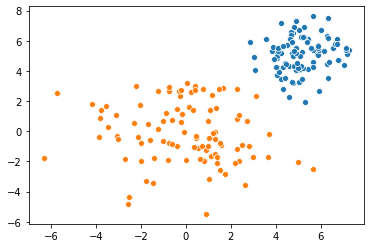

In [57]:

p=torch.ones(N).detach().requires_grad_(True).to(device)
q=5.*torch.ones(N).detach().requires_grad_(True).to(device)

x=torch.randn(n_samples,N).to(device)
var=(p*x+q).detach().cpu()
tar=target.sample((n_samples,)).cpu()


sns.scatterplot(var[:,0],var[:,1])
sns.scatterplot(tar[:,0],tar[:,1])



In [58]:
KLs=[]
ELBOs=[]
H_grad=[]


ps=[]
qs=[]

In [59]:
lr=0.05
with trange(1000) as tr :
    for _ in tr:
        x=torch.randn(n_samples,N).to(device)

        n_samples=x.shape[0]
        sample=p*x+q

        K=KL(sample.view(-1,N),target.sample((n_samples,)),k=5,beta=.5)
        LL=2*loglikelihood(sample,y_data).mean()
        ELBO=K-LL

        KLs.append(K.item())
        ELBOs.append(ELBO.item())
        tr.set_postfix(ELBO=ELBO.item(), LogLike=LL.item(), KL=K.item())

        p_grad=torch.autograd.grad(ELBO,p,retain_graph=True)
        q_grad=torch.autograd.grad(ELBO,q,retain_graph=True)

       # print(lp_grad_p[0])

        p.data.add_(-lr*p_grad[0])
        q.data.add_(-lr*q_grad[0])
        ps.append(p.data.clone())
        qs.append(q.data.clone())

100%|██████████| 1000/1000 [00:04<00:00, 211.64it/s, ELBO=42.8, KL=10.6, LogLike=-32.3]


In [60]:
print(q.data)
print(p.data)

tensor([4.8777, 0.0711, 0.0330, 0.0922, 0.1011, 0.0748, 0.0714, 0.0561, 0.0568,
        0.0439], device='cuda:0')
tensor([1.6747e-03, 2.1871e+00, 2.1813e+00, 2.2390e+00, 2.2100e+00, 2.1914e+00,
        2.1602e+00, 2.2062e+00, 2.1854e+00, 2.2115e+00], device='cuda:0')


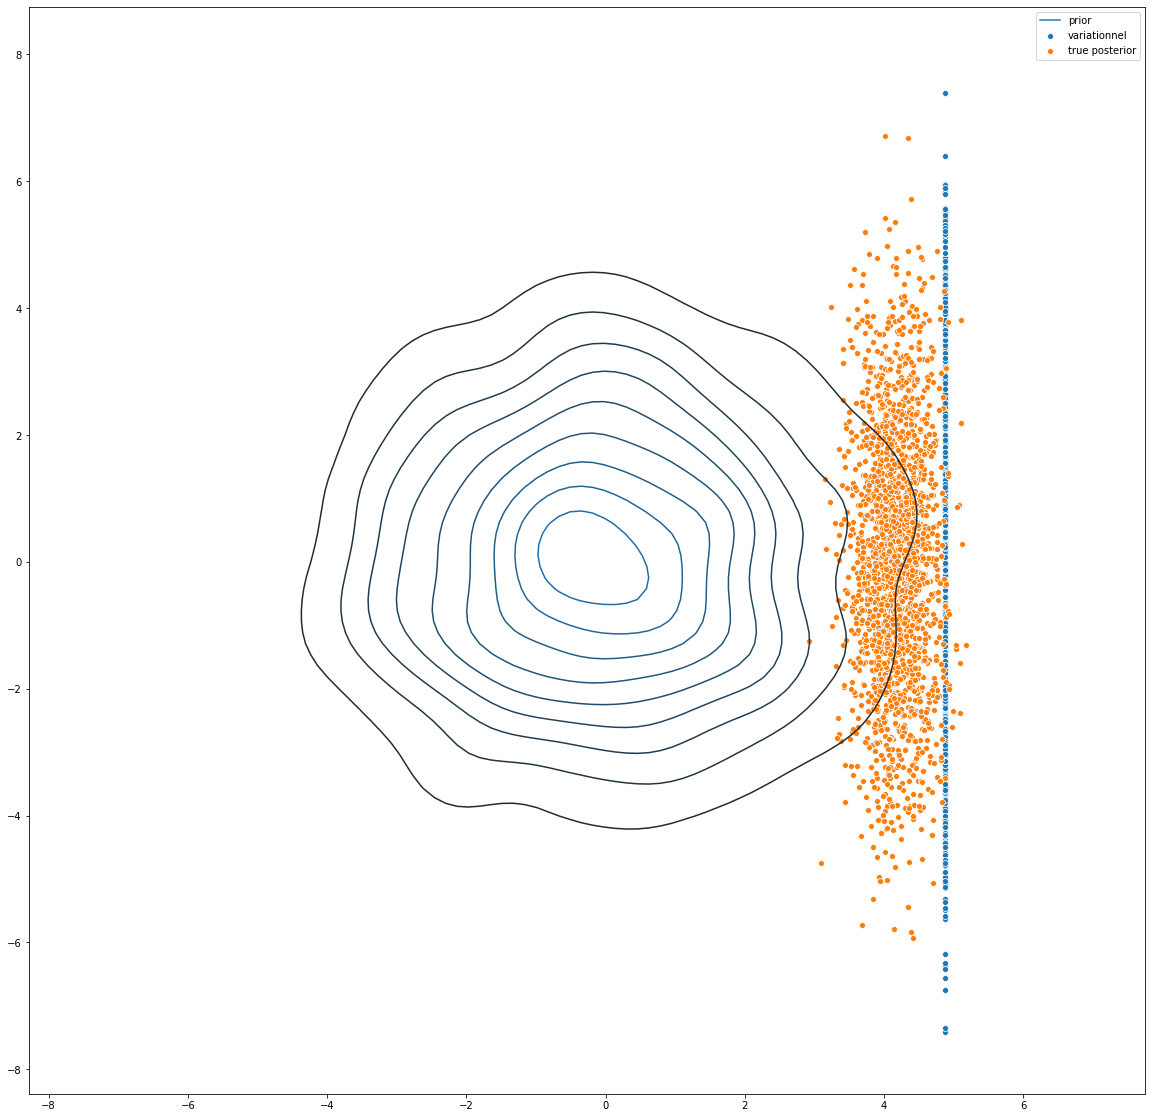

In [61]:
x=torch.randn(2000,N).to(device)
var=(p*x+q).detach().cpu().numpy()
tar=target.sample((2000,)).cpu().numpy()

true_posterior=posterior.sample((2000,)).numpy()

plt.subplots(figsize=(20,20))

"""
sns.distplot(var, label='variationnel')
sns.distplot(tar,label='prior')
sns.distplot(data.cpu(),label='data')
sns.distplot(true_posterior, label='true posterior')
plt.legend()
"""
sns.kdeplot(tar[:,0],tar[:,1],label='prior')
sns.scatterplot(var[:,0],var[:,1], label='variationnel')
sns.scatterplot(true_posterior[:,0],true_posterior[:,1], label='true posterior')#shade=True
plt.legend()

#plt.scatter(var[:,0],var[:,1],alpha=0.5, label='variationnel')
#plt.scatter(tar[:,0],tar[:,1],alpha=0.5)
#plt.legend()
#plt.axis('scaled')

torch.Size([999])


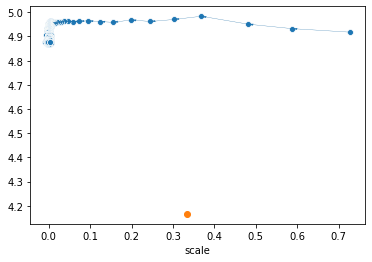

In [62]:
from matplotlib.collections import LineCollection

dim=0
steps=-1
p0=torch.stack(ps)[:steps,dim].cpu()
q0=torch.stack(qs)[:steps,dim].cpu()

import numpy as np


line=sns.scatterplot(p0.cpu(),q0.cpu())

mid=1#1*(len(p0)//10)
eps=1
for mid in range(20):
    arrow = p0[mid], q0[mid], -p0[mid]+p0[mid+eps], -q0[mid]+q0[mid+eps]
    plt.arrow(*arrow, shape='full', lw=0.01, length_includes_head=True, head_width=.008)

plt.scatter(sigma_posterior[dim],mean_posterior[dim], marker='o',label='target')
    
ax.set_ylabel("mode")
plt.xlabel("scale")

print(p0.shape)

Text(0.5, 0, 'scale')

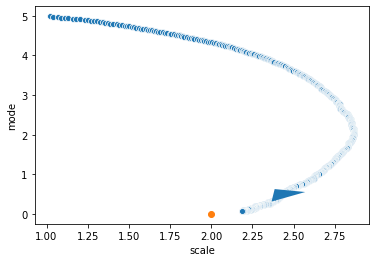

In [63]:
dim=1
p0=torch.stack(ps)[:,dim].cpu()
q0=torch.stack(qs)[:,dim].cpu()

fig,ax=plt.subplots()
sns.scatterplot(p0.cpu(),q0.cpu())
ax.set_ylabel("mode")

mid=(len(p0)//2)
eps=200
arrow = p0[mid], q0[mid], -p0[mid]+p0[mid+eps], -q0[mid]+q0[mid+eps]
plt.arrow(*arrow, shape='full', lw=0, length_includes_head=True, head_width=.2)
plt.scatter(sigma_posterior[dim],mean_posterior[dim], marker='o',label='target')

plt.xlabel("scale")



10.563711166381836


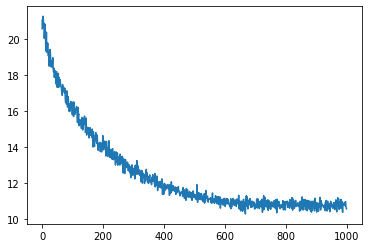

In [64]:
import matplotlib.pyplot as plt
plt.plot(KLs)
print(KLs[-1])

# beta in NN estimation of KL #
nb_samples= 100

experimentation on multivariate gaussian 

|dimension|beta|
|---|---|
|2|0.95|
|3|0.9|
|4|0.85|
|5| 0.8|
|10|0.7|
|20|0.64|
|30| 0.61|
|40| 0.59|
|50|0.583|
|100|0.56|
|150|0.545|
|200|0.54|
|300|0.53|
|500|0.525|
|1000|0.52|


tensor(0.4642)


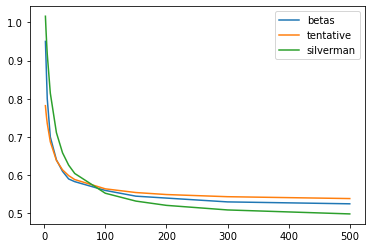

In [633]:
last=-1
dimensions=torch.Tensor([2,3,4,5,10,20,30,40,50,100,150,200,300,500,1000])
betas=torch.Tensor([0.95,0.9,0.85,.8,.7,.64,.61,.59,.583,.56,.545,.54,.53,.525,.52])
silverman=(4/(dimensions[:last]+2))**(1/(dimensions[:last]+4))*100**(-1/(dimensions[:last]+4))
plt.plot(dimensions[:last],betas[:last], label='betas')
plt.plot(dimensions[:last],1-0.47*silverman, label='tentative')
plt.plot(dimensions[:last],1.48-silverman, label='silverman')

print(silverman[0])
plt.legend()

# consistency #

In [145]:
import timeit
import numpy as np
from tqdm import trange

n_samples=100
target = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1.]))
lr=0.1


NN_ps=[]
NN_qs=[]
NN_time=[]
for n in trange(20):
    p=torch.tensor([1.]).uniform_(0.5,5.).detach().requires_grad_(True).to(device)
    q=torch.tensor([10.]).uniform_(0.,10.).detach().requires_grad_(True).to(device)
    start = timeit.default_timer()

    for _ in range(2000):
        x=torch.randn(n_samples).to(device)

        n_samples=x.shape[0]
        sample=p*x+q

        K=KL(sample.view(-1,1),target.sample((n_samples,)).to(device),k=5,device='cpu')

        p_grad=torch.autograd.grad(K,p,retain_graph=True)
        q_grad=torch.autograd.grad(K,q,retain_graph=True)

        p.data.add_(-lr*p_grad[0])
        q.data.add_(-lr*q_grad[0])

    NN_ps.append((p.item()))
    NN_qs.append((q.item()))
    stop = timeit.default_timer()
    NN_time.append(stop - start)
                 

    

100%|██████████| 20/20 [01:34<00:00,  4.70s/it]


average time [s]: 4.685762455058284
mean: (-0.04008566774427891, 0.4569391992067915)
scale: (1.1856259882450104, 0.2521446274233837)


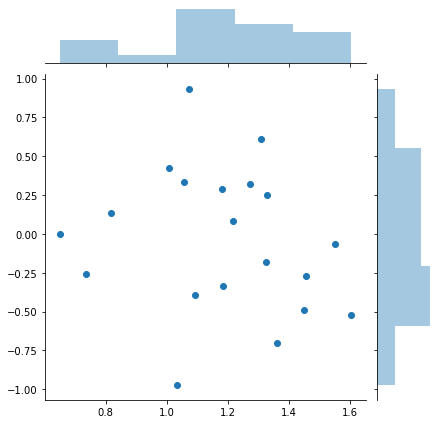

In [146]:
sn.jointplot(NN_ps,NN_qs)
print('average time [s]: '+str(np.mean(NN_time)))
print('mean: '+str((np.mean(NN_qs),np.std(NN_qs))))
print('scale: '+str((np.mean(NN_ps),np.std(NN_ps))))

In [ ]:
import timeit
import numpy as np
from tqdm import trange

n_samples=100
target = torch.distributions.Normal(torch.tensor([0.0],device=device), torch.tensor([1.],device=device))
lr=0.1


SSGE_ps=[]
SSGE_qs=[]
SSGE_time=[]
for n in trange(20):
    p=torch.Tensor(1).uniform_(0.5,5.).detach().requires_grad_(True).to(device)
    q=torch.Tensor(1).uniform_(0.,10.).detach().requires_grad_(True).to(device)
    start = timeit.default_timer()

    for _ in range(2000):
        x=torch.randn(n_samples).to(device)

        n_samples=x.shape[0]
        repeat_arg = (n_samples,) + (1,) * len(p.size())
        pr=p.repeat(*repeat_arg)
        qr=q.repeat(*repeat_arg)
        y=pr*x+qr

        sample=y[0].unsqueeze(-1)

        lp=-target.log_prob(sample).mean()
        lp_grad_p=torch.autograd.grad(lp,p,retain_graph=True)
        lp_grad_q=torch.autograd.grad(lp,q,retain_graph=True)


        I=torch.eye(n_samples).to(device)
        Jp = torch.autograd.grad(y, pr,
                              grad_outputs=I,
                              retain_graph=True)
        Jq = torch.autograd.grad(y, qr,
                              grad_outputs=I,
                              retain_graph=True)
        Jp[0].shape
        y_grad=torch.stack([Jp[0],Jq[0]],dim=1).to(device)


        grad_estimator = EntropyGradient(eta=0.1)
        entropy_grad = grad_estimator(sample, y_grad)

        p.data.add_(-lr*(entropy_grad[0]+lp_grad_p[0]))
        q.data.add_(-lr*(entropy_grad[1]+lp_grad_q[0]))

    SSGE_ps.append((p.item()))
    SSGE_qs.append((q.item()))
    stop = timeit.default_timer()
    SSGE_time.append(stop - start)
                 


 10%|█         | 2/20 [01:08<10:11, 33.98s/it]

NN average time [s]: 4.685762455058284
NN mean: (-0.04008566774427891, 0.4569391992067915)
NN scale: (1.1856259882450104, 0.2521446274233837)
SSGE average time [s]: nan
SSGE mean: (nan, nan)
SSGE scale: (nan, nan)


/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/yann/anaconda3/envs/bnn/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


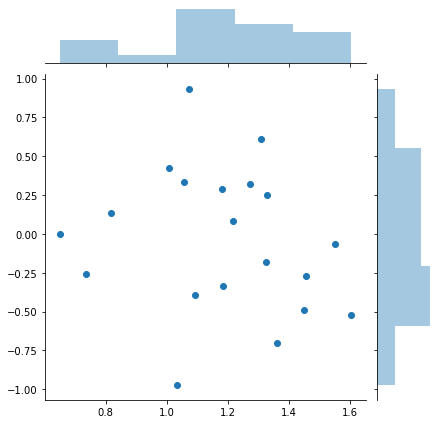

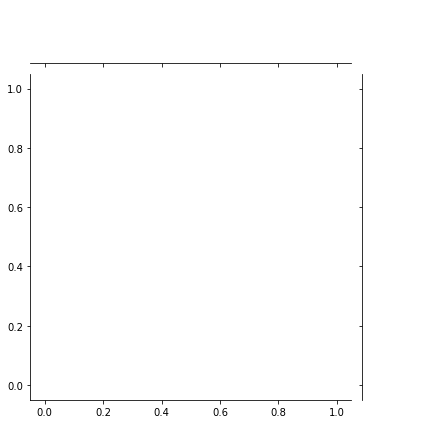

In [148]:
sn.jointplot(NN_ps,NN_qs)
sn.jointplot(SSGE_ps,SSGE_qs)
print('NN average time [s]: '+str(np.mean(NN_time)))
print('NN mean: '+str((np.mean(NN_qs),np.std(NN_qs))))
print('NN scale: '+str((np.mean(NN_ps),np.std(NN_ps))))
print('SSGE average time [s]: '+str(np.mean(SSGE_time)))
print('SSGE mean: '+str((np.mean(SSGE_qs),np.std(SSGE_qs))))
print('SSGE scale: '+str((np.mean(SSGE_ps),np.std(SSGE_ps))))
